- ***Proyecto:*** US Housing Market Predictor
- ***Autor:*** Marcos Ibarra https://github.com/MRCSIBR


## Preparación y Fusión de Datos (Data Wrangling)

En este notebook limpiaremos y unificaremos los datos (Semanal/Mensual para casas, Mensual para desempleo, Trimestral para PBI). Necesitamos unificarlos.


1. Introducción

En este notebook realizaremos la extracción, transformación y carga (ETL) de datos inmobiliarios y macroeconómicos de EE.UU.
El objetivo es unificar series temporales con diferentes frecuencias (semanal, mensual y trimestral) en un solo ***dataset mensual limpio***, listo para entrenar modelos de Machine Learning.
Fuentes de Datos:

    Redfin Data (data.xlsx): Datos del mercado inmobiliario (Precios, Inventario, Ventas).

    FRED UNRATE (UNRATE_FRED.csv): Tasa de desempleo mensual.

    FRED GDP (GDP.csv): Producto Interno Bruto trimestral.

## 2. Importando librerias

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para gráficos
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


## 3. Extracción de Datos (Extract)

In [7]:
# 1. Cargar Datos Inmobiliarios (Redfin)
# Asegúrate de que el nombre del archivo coincida exactamente con el que tienes en tu carpeta
df_housing_raw = pd.read_excel('data/data.xlsx')

# 2. Cargar Desempleo (UNRATE)
df_unrate_raw = pd.read_csv('data/UNRATE_FRED.csv')

# 3. Cargar PBI (GDP)
df_gdp_raw = pd.read_csv('data/GDP.csv')

print("Housing shape:", df_housing_raw.shape)
print("Unemployment shape:", df_unrate_raw.shape)
print("GDP shape:", df_gdp_raw.shape)

Housing shape: (973, 20)
Unemployment shape: (909, 2)
GDP shape: (169, 2)


## 4. Transformación y Limpieza (Transform)

El objetivo aquí es alinear todo a una frecuencia Mensual (Fin de Mes).
4.1. Procesamiento de Datos Inmobiliarios (Redfin)

Los datos de Redfin suelen venir semanales o mensuales sucios. Vamos a estandarizarlos.

In [11]:
# Copia para no modificar el original
df_housing = df_housing_raw.copy()

# Convertir fecha
# Ajusta 'Week of Period End' si tu columna tiene otro nombre
df_housing['date'] = pd.to_datetime(df_housing['Week of Period End']) 
df_housing.set_index('date', inplace=True)

# Filtrar datos desde 2013 en adelante (para consistencia con tu análisis previo)
df_housing = df_housing[df_housing.index.year >= 2013]

# RESAMPLING (Muestreo a Mensual)
# - Precios: Usamos la MEDIANA del mes.
# - Inventario/Ventas: Usamos la SUMA o el PROMEDIO según la lógica de negocio.
#   Nota: Para inventario, el promedio mensual es más representativo que la suma.
#   Para casas vendidas, la suma es lo correcto.

df_housing_monthly = df_housing.resample('ME').agg({
    'Median Sale Price': 'median',
    'Inventory': 'mean',        # Stock promedio disponible en el mes
    'Homes Sold': 'sum',        # Total vendido
    'New Listings': 'sum'       # Total entrante
})

# Renombrar columnas para facilitar el manejo
df_housing_monthly.columns = ['Price', 'Inventory', 'Homes_Sold', 'New_Listings']

print(df_housing_monthly.head())

               Price      Inventory  Homes_Sold  New_Listings
date                                                         
2013-01-31  285000.0  252388.428571      327279        518768
2013-02-28  307000.0  257755.571429      336366        536337
2013-03-31  320000.0  264344.428571      439181        642959
2013-04-30  325950.0  277519.857143      482175        730261
2013-05-31  345000.0  288283.142857      560079        746030


## 4.2. Procesamiento de Variables Macroeconómicas (GDP & Desempleo)

In [18]:
# --- DESEMPLEO (Mensual) ---
df_unrate = df_unrate_raw.copy()
df_unrate['DATE'] = pd.to_datetime(df_unrate['DATE'])
df_unrate.set_index('DATE', inplace=True)
# Aseguramos que esté a fin de mes para coincidir con Housing
df_unrate = df_unrate.resample('ME').mean()
df_unrate.columns = ['Unemployment_Rate']


# --- GDP (Trimestral -> Mensual) ---
df_gdp = df_gdp_raw.copy()
df_gdp['DATE'] = pd.to_datetime(df_gdp['DATE'])
df_gdp.set_index('DATE', inplace=True)

# Upsampling: De Trimestral a Mensual
# Usamos interpolación lineal para llenar los meses intermedios suavemente
df_gdp_monthly = df_gdp.resample('ME').interpolate(method='linear')
df_gdp_monthly.columns = ['GDP']

# Filtrar también desde 2013
df_unrate = df_unrate[df_unrate.index.year >= 2013]
df_gdp_monthly = df_gdp_monthly[df_gdp_monthly.index.year >= 2013]

print("GDP Mensualizado (head):")
print(df_gdp_monthly.head())

GDP Mensualizado (head):
            GDP
DATE           
2013-01-31  NaN
2013-02-28  NaN
2013-03-31  NaN
2013-04-30  NaN
2013-05-31  NaN


## 5. Fusión de Datos (Merge)

Unimos los tres dataframes usando el índice de fecha.

In [16]:
# Unir (Join) usando el índice
df_master = df_housing_monthly.join([df_unrate, df_gdp_monthly], how='inner')

# Verificar si hay nulos
print(f"Valores nulos antes de limpieza:\n{df_master.isna().sum()}")

# Si hay pocos nulos (por diferencias de días al final del mes), llenamos hacia adelante
df_master.fillna(method='ffill', inplace=True)
df_master.dropna(inplace=True) # Eliminar lo que no se pueda salvar

print(f"\nDimensiones finales del Dataset Maestro: {df_master.shape}")
display(df_master.head())

Valores nulos antes de limpieza:
Price                  0
Inventory              0
Homes_Sold             0
New_Listings           0
Unemployment_Rate      0
GDP                  109
dtype: int64

Dimensiones finales del Dataset Maestro: (0, 6)


/tmp/ipykernel_13712/2690207940.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_master.fillna(method='ffill', inplace=True)


,Price,Inventory,Homes_Sold,New_Listings,Unemployment_Rate,GDP


In [19]:
# El dataset anterior no muestra ningun data, podemos corregirlo empezando desde el dia `1' de cada mes


# --- 1. PROCESAMIENTO HOUSING ---
df_housing = df_housing_raw.copy()
df_housing['date'] = pd.to_datetime(df_housing['Week of Period End'])
df_housing.set_index('date', inplace=True)
df_housing = df_housing[df_housing.index.year >= 2013]

# Resample a 'MS' (Month Start - Inicio de mes) en lugar de 'M' (Fin de mes)
df_housing_monthly = df_housing.resample('MS').agg({
    'Median Sale Price': 'median',
    'Inventory': 'mean',
    'Homes Sold': 'sum',
    'New Listings': 'sum'
})
df_housing_monthly.columns = ['Price', 'Inventory', 'Homes_Sold', 'New_Listings']


# --- 2. PROCESAMIENTO DESEMPLEO ---
df_unrate = df_unrate_raw.copy()
df_unrate['DATE'] = pd.to_datetime(df_unrate['DATE'])
df_unrate.set_index('DATE', inplace=True)
df_unrate = df_unrate[df_unrate.index.year >= 2013]

# Resample a 'MS' (Month Start) para asegurar que sea día 1
df_unrate = df_unrate.resample('MS').mean()
df_unrate.columns = ['Unemployment_Rate']


# --- 3. PROCESAMIENTO GDP (Trimestral -> Mensual) ---
df_gdp = df_gdp_raw.copy()
df_gdp['DATE'] = pd.to_datetime(df_gdp['DATE'])
df_gdp.set_index('DATE', inplace=True)
df_gdp = df_gdp[df_gdp.index.year >= 2013]

# Upsampling a 'MS' (Month Start) e interpolación
df_gdp_monthly = df_gdp.resample('MS').interpolate(method='linear')
df_gdp_monthly.columns = ['GDP']

# --- VERIFICACIÓN DE ÍNDICES ---
print("Índice Housing (ejemplo):", df_housing_monthly.index[0])
print("Índice UNRATE (ejemplo):", df_unrate.index[0])
print("Índice GDP (ejemplo):", df_gdp_monthly.index[0])
# Todos deberían decir algo como '2013-01-01'

  

Índice Housing (ejemplo): 2013-01-01 00:00:00
Índice UNRATE (ejemplo): 2013-01-01 00:00:00
Índice GDP (ejemplo): 2013-01-01 00:00:00


In [20]:
## Fusion de datos corregida

In [22]:
# Unir (Join)
# Usamos 'inner' para quedarnos solo con las fechas donde tenemos datos de las 3 fuentes
df_master = df_housing_monthly.join([df_unrate, df_gdp_monthly], how='inner')

print(f"Valores nulos antes de limpieza:\n{df_master.isna().sum()}")

# Llenar nulos si existen (por ejemplo, si el GDP llega un mes más corto)
df_master.fillna(method='ffill', inplace=True) # Rellenar con el valor anterior
df_master.dropna(inplace=True) # Eliminar lo que quede vacio

print(f"\nDimensiones finales del Dataset Maestro: {df_master.shape}")
display(df_master.head())
display(df_master.tail())

Valores nulos antes de limpieza:
Price                0
Inventory            0
Homes_Sold           0
New_Listings         0
Unemployment_Rate    0
GDP                  0
dtype: int64

Dimensiones finales del Dataset Maestro: (109, 6)


/tmp/ipykernel_13712/1272694499.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_master.fillna(method='ffill', inplace=True) # Rellenar con el valor anterior


,Price,Inventory,Homes_Sold,New_Listings,Unemployment_Rate,GDP
2013-01-01,285000.0,252388.428571,327279,518768,8.0,16648.189000
2013-02-01,307000.0,257755.571429,336366,536337,7.7,16675.021667
2013-03-01,320000.0,264344.428571,439181,642959,7.5,16701.854333
2013-04-01,325950.0,277519.857143,482175,730261,7.6,16728.687000
2013-05-01,345000.0,288283.142857,560079,746030,7.5,16803.737333


,Price,Inventory,Homes_Sold,New_Listings,Unemployment_Rate,GDP
2021-09-01,480000.0,149671.285714,672689,723019,4.8,24379.393000
2021-10-01,495000.0,141749.285714,646206,660084,4.5,24654.603000
2021-11-01,494950.0,122354.571429,624577,517374,4.2,24779.440667
2021-12-01,487500.0,99451.000000,629448,386480,3.9,24904.278333
2022-01-01,473000.0,96124.857143,437517,485082,4.0,25029.116000


6. Análisis Exploratorio de Datos (EDA)

Vamos a visualizar si la correlación que de el análisis original es correcta: "A menor inventario, mayor precio".

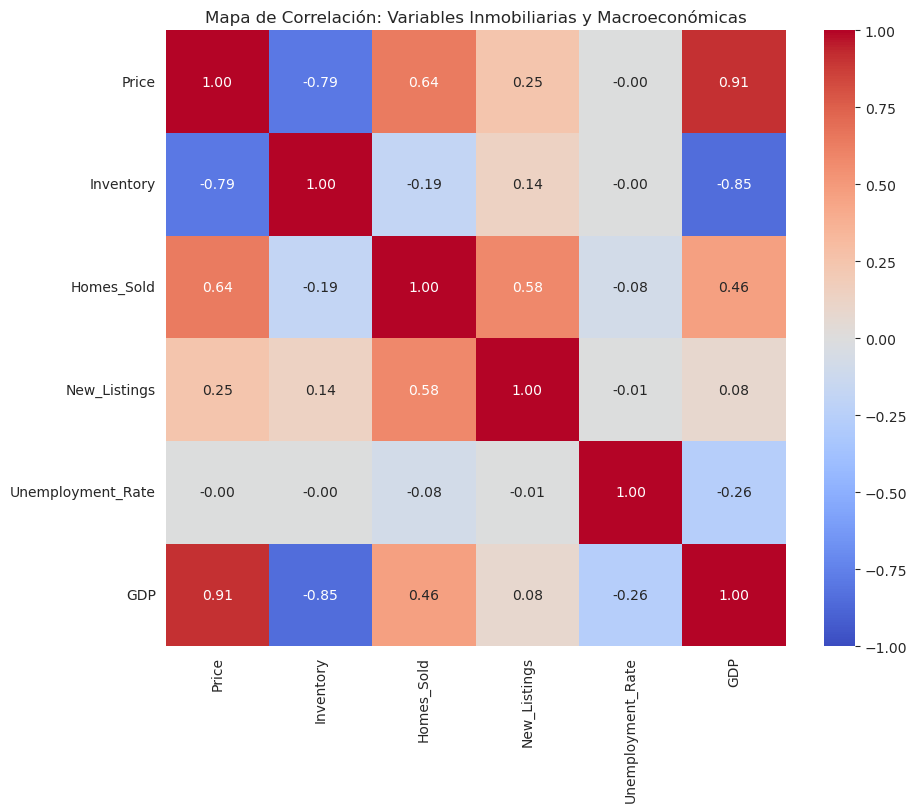

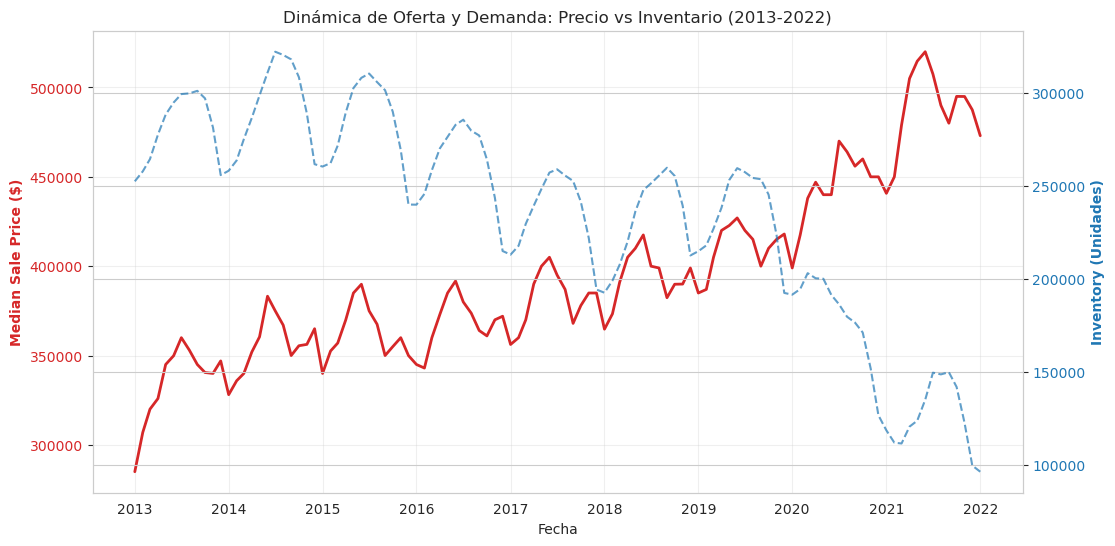

In [23]:
# 6.1. Mapa de Calor de Correlaciones
plt.figure(figsize=(10, 8))
correlation_matrix = df_master.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Mapa de Correlación: Variables Inmobiliarias y Macroeconómicas")
plt.show()

# 6.2. Gráfico de Doble Eje: Precio vs Inventario
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eje Y izquierdo: Precio
color_price = 'tab:red'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Median Sale Price ($)', color=color_price, fontweight='bold')
ax1.plot(df_master.index, df_master['Price'], color=color_price, linewidth=2, label='Precio')
ax1.tick_params(axis='y', labelcolor=color_price)

# Eje Y derecho: Inventario
ax2 = ax1.twinx() 
color_inv = 'tab:blue'
ax2.set_ylabel('Inventory (Unidades)', color=color_inv, fontweight='bold')
ax2.plot(df_master.index, df_master['Inventory'], color=color_inv, linestyle='--', alpha=0.7, label='Inventario')
ax2.tick_params(axis='y', labelcolor=color_inv)

# Títulos y Grid
plt.title('Dinámica de Oferta y Demanda: Precio vs Inventario (2013-2022)')
ax1.grid(True, alpha=0.3)
plt.show()

# 7. Ingeniería de Características (Feature Engineering)

Aquí es donde ocurre la magia para Machine Learning en series de tiempo.
El modelo no puede saber el GDP o el desempleo de "mañana". Solo sabe lo que pasó "ayer" o "el mes pasado".

Por eso crearemos Lags (Rezagos). Le enseñaremos al modelo a mirar los últimos 3 meses para predecir el precio del mes siguiente.

In [24]:
df_ml = df_master.copy()

# 1. EL OBJETIVO (TARGET): Predecir el precio del MES SIGUIENTE (t+1)
df_ml['Target_Price_Next_Month'] = df_ml['Price'].shift(-1)

# 2. LOS FEATURES (HISTORIA): Datos de hace 1, 2 y 3 meses (t, t-1, t-2)
# Esto ayuda al modelo a capturar tendencias a corto plazo
feature_cols = ['Price', 'Inventory', 'Homes_Sold', 'New_Listings', 'Unemployment_Rate', 'GDP']

for col in feature_cols:
    for lag in [1, 2, 3]: 
        col_name = f'{col}_lag{lag}'
        df_ml[col_name] = df_ml[col].shift(lag)

# 3. Limpieza final
# Al hacer shift, se crean NaNs al principio (falta historia) y al final (falta futuro).
# Los eliminamos.
df_ml.dropna(inplace=True)

print("Dimensiones para ML:", df_ml.shape)
print("\nEjemplo de datos (Features históricos vs Target futuro):")
display(df_ml[['Price_lag1', 'Inventory_lag1', 'Target_Price_Next_Month']].head())

Dimensiones para ML: (105, 25)

Ejemplo de datos (Features históricos vs Target futuro):


,Price_lag1,Inventory_lag1,Target_Price_Next_Month
2013-04-01,320000.0,264344.428571,345000.0
2013-05-01,325950.0,277519.857143,349900.0
2013-06-01,345000.0,288283.142857,360000.0
2013-07-01,349900.0,294798.000000,353045.0
2013-08-01,360000.0,299336.285714,345000.0


## 8. Guardar Dataset

In [26]:
df_ml.to_csv('data/housing_market_master_ml.csv')
print("¡Archivo exportado con éxito! Listo para entrenar modelos.")

¡Archivo exportado con éxito! Listo para entrenar modelos.
